In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

import graphviz
import pydotplus
import io
from scipy import misc

In [2]:
all_dataset = pd.read_csv("data/arrhythmia.data", header=None)

In [3]:
chosen_column = [0] + [i for i in range(3, 15)] + [all_dataset.columns[-1]]
max_trash = 20

In [4]:
def clean_data(data):
    for col in data.columns:
        trash_row = (data[col] == "?")
        good_row = (data[col] != "?")
        if sum(trash_row) < max_trash:
            data = data[good_row]
        else:
            aver =  pd.to_numeric(data[good_row][col]).mean()
            data.loc[trash_row, col] = aver
        data[col] = pd.to_numeric(data[col])
        data[col] -= data[col].min()
    return data

In [5]:
def split_train_test(df):
    margin = int(0.8 * len(df))
    df = df.sample(frac=1)
    train = df.iloc[:margin]
    test = df.iloc[margin:]
    return train, test

In [6]:
def from_data_to_xy(data):
    x = np.array(data[data.columns[:-1]], dtype=float)
    y = np.array(data[data.columns[-1]], dtype=float)
    return x, y

In [73]:
def clf_acc(data, clf):
    train_data, test_data = split_train_test(data)
    train_x, train_y = from_data_to_xy(train_data)
    test_x, test_y = from_data_to_xy(test_data)
    clf_fit = clf.fit(train_x, train_y)
    y_pred = clf_fit.predict(test_x)
    acc = sum(y_pred == test_y)  / test_y.shape[0]
    return acc

In [8]:
dataset = all_dataset[chosen_column]
clean_dataset = clean_data(dataset)

/home/ahavriushen/Desktop/uni_proj/stat_learning/venv/lib/python3.6/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [9]:
def cv_accuracy(data, classifier, num_iter=100):
    accuracy = []
    for i in range(num_iter):
        acc = clf_acc(data, classifier)
        accuracy.append(acc)
    return accuracy

In [13]:
def show_tree(tree, features, path):
    f = io.StringIO()
    export_graphviz(tree, out_file=f, feature_names=features)
    pydotplus.graph_from_dot_data(f.getvalue()).write_png(path)
    #img = misc.imread(path)
    img = plt.imread(path)
    plt.rcParams["figure.figsize"] = (20, 20)
    plt.imshow(img)

In [ ]:
## accuracy = 0.53 for full tree
## accuracy with min_samples_split=10 => 0.56
## accuracy with min_samples_split=10 => 0.59
##({'max_depth': 6, 'min_samples_split': 24}, 0.6175637393767706, 0.6741573033707865)

0.5955056179775281


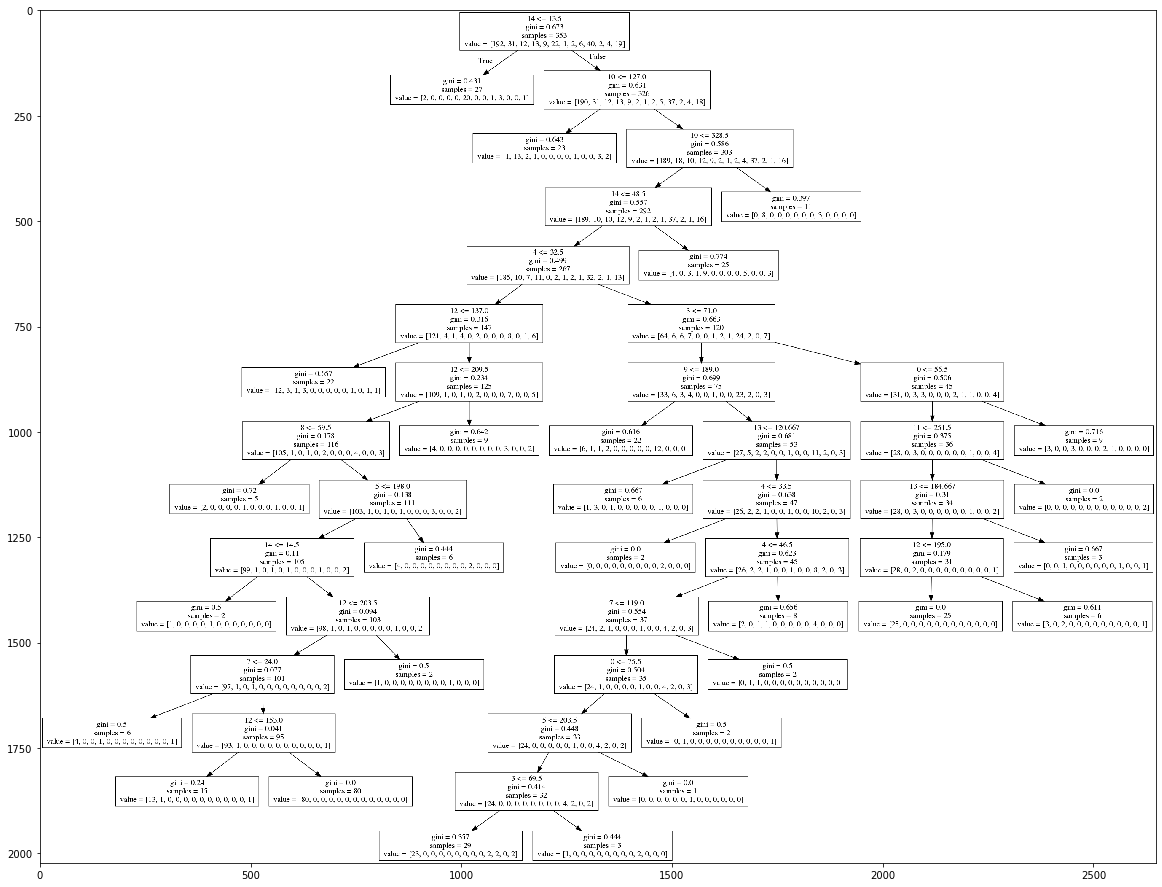

In [20]:
clf = DecisionTreeClassifier(min_samples_split=30)

train_data, test_data = split_train_test(clean_dataset)
train_x, train_y = from_data_to_xy(train_data)
test_x, test_y = from_data_to_xy(test_data)
clf_fit = clf.fit(train_x, train_y)
y_pred = clf_fit.predict(test_x)
acc = sum(y_pred == test_y)  / test_y.shape[0]
print(acc)
show_tree(clf_fit, chosen_column[:-1], "dec_tree_02.png")
#tree_plot = tree.plot_tree(clf_fit, max_depth=10) 

In [90]:
def grid_search(data_, clf, param, scoring):
    train_data, test_data = split_train_test(data_)
    train_x, train_y = from_data_to_xy(train_data)
    test_x, test_y = from_data_to_xy(test_data)
    grid_clf = GridSearchCV(clf, param, cv=10, scoring=scoring)
    grid_clf_fit = grid_clf.fit(train_x, train_y)
    model = grid_clf_fit.best_estimator_
    model_fit = model.fit(train_x, train_y)
    y_pred = model_fit.predict(test_x)
    acc = sum(y_pred == test_y)  / test_y.shape[0]
    return grid_clf_fit.best_params_, grid_clf_fit.best_score_, acc, model_fit

In [91]:
parameters={'min_samples_split': range(2, 80, 2),
            'max_depth': range(1, 50, 2)}
clf_dt = DecisionTreeClassifier()
answer = grid_search(clean_dataset, clf_dt, parameters, 'accuracy')
print(answer[:-1])
show_tree(answer[-1], chosen_column[:-1], "dec_tree_02.png")

/home/ahavriushen/Desktop/uni_proj/stat_learning/venv/lib/python3.6/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


({'max_depth': 6, 'min_samples_split': 24}, 0.6175637393767706, 0.6741573033707865)


/home/ahavriushen/Desktop/uni_proj/stat_learning/venv/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [ ]:
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1e-3,
    max_depth=10, random_state=10)
ac = check_accuracy(clean_dataset, clf, num_iter=10)
print(np.mean(ac))

In [ ]:
clf = RandomForestClassifier(n_estimators=100, max_depth=2,
                             random_state=10)
ac = check_accuracy(clean_dataset, clf, num_iter=10)
print(np.mean(ac))

In [ ]:
#1. Вирішуюче дерево
2. Бустінг 
3. Випадковий ліс

Оберіть два найбільш значущих регресори (будь-яким методом) та намалюйте області класифікації в R^2.

Для кожного методу проведіть підбір параметрів для потреби (для цього можна скористатися модулем sklearn.model_selection.GridSearchCV).
